In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os

import statsmodels

In [2]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (12, 7)
pd.set_option('display.float_format','{:.4f}'.format)

# Wczytanie danych
(interwał dzienny)


In [3]:
gaz = pd.read_csv(os.path.join("Futures", "Daily_Natural_Gas_Futures_Contract_1.csv"), skiprows=5, parse_dates=['Data'], names=["Data", "Cena gazu [USD/Million Btu]"])

In [4]:
ropa_csv = pd.read_csv(os.path.join("Futures", "Brent_Crude_Oil_Last_Day_BZ=F.csv"))
ropa = pd.DataFrame()

In [5]:
ropa["Data"] = ropa_csv["Date"]
ropa["Cena ropy [USD/Barrel]"] = ropa_csv["Close*"]

In [6]:
ropa.dtypes

Data                       object
Cena ropy [USD/Barrel]    float64
dtype: object

In [7]:
ropa = ropa.astype({"Data": "datetime64[ns]"})

In [8]:
gaz.dtypes

Data                           datetime64[ns]
Cena gazu [USD/Million Btu]           float64
dtype: object

In [9]:
df = gaz.merge(ropa, on="Data", how="inner").dropna() # zbiorcza tabela połączona po danych - do analizy dwuwymiarowej

In [10]:
# df = df.reindex(index=df.index[::-1])
# df = df[::-1].reset_index(drop = True)

df = df.iloc[::-1]
df = df.reset_index(drop=True)

In [11]:
df.head()

,Data,Cena gazu [USD/Million Btu],Cena ropy [USD/Barrel]
0,2007-07-30,6.4990,75.7400
1,2007-07-31,6.1910,77.0500
2,2007-08-01,6.3520,75.3500
3,2007-08-02,6.1060,75.7600
4,2007-08-03,6.0900,74.7500


In [12]:
y_gaz = df['Cena gazu [USD/Million Btu]']
y_ropa = df['Cena ropy [USD/Barrel]']

### Przygotowanie danych

Zwroty logarytmiczne
$$ y_t = \ln(\frac{x_t}{x_{t-1}})$$

In [13]:
df['przyrosty_log_gaz'] = np.log(y_gaz).diff().dropna()
df['przyrosty_log_ropa'] = np.log(y_ropa).diff().dropna()

In [14]:
df.shape

(3873, 5)

In [15]:
df.dropna(inplace = True)
df = df.reset_index(drop=True) #!?

In [16]:
df.head()

,Data,Cena gazu [USD/Million Btu],Cena ropy [USD/Barrel],przyrosty_log_gaz,przyrosty_log_ropa
0,2007-07-31,6.1910,77.0500,-0.0486,0.0171
1,2007-08-01,6.3520,75.3500,0.0257,-0.0223
2,2007-08-02,6.1060,75.7600,-0.0395,0.0054
3,2007-08-03,6.0900,74.7500,-0.0026,-0.0134
4,2007-08-06,6.2080,71.1700,0.0192,-0.0491


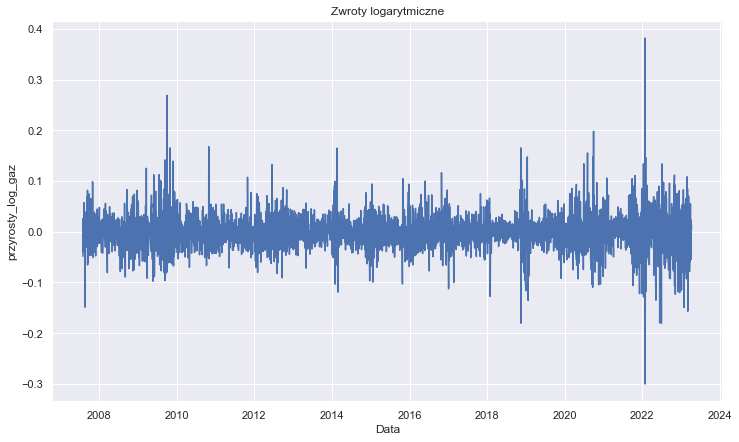

In [17]:
sns.lineplot(x=df.Data, y=df.przyrosty_log_gaz)
plt.title('Zwroty logarytmiczne')
plt.xlabel('Data')
# plt.savefig('log_przyrosty_gazu.png')
plt.show()

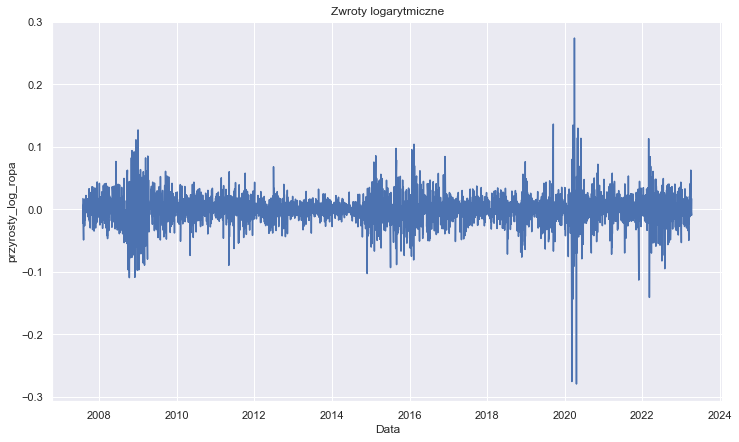

In [18]:
sns.lineplot(x=df.Data, y=df.przyrosty_log_ropa)
plt.title('Zwroty logarytmiczne')
plt.xlabel('Data')
# plt.savefig('log_przyrosty_ropy.png')
plt.show()

---

#  Rozkład maksimum, podejście pierwsze

a L przyjmuje dodatnie zwroty logarytmiczne R.
Maksimum jest liczone dla step = 10, a rozkład jest dopasowywane metodą największej wiarygodności, wybieram 1800 ostatnich obserwacji

In [19]:
import scipy.stats as sp

In [20]:
n = 1800
step = 10

In [21]:
# new_df = df.iloc[-n:, :].copy()

# GAZ

In [22]:
X_gaz = df['przyrosty_log_gaz'][df['przyrosty_log_gaz'] > 0]

In [23]:
# wybieram 1800 punktów (ostatnich, dodatnich logarytmicznych stóp zwrotu)
gaz_1800 = X_gaz[-n:]

In [24]:
gaz_1800 = gaz_1800.reset_index(drop=True)

In [25]:
gaz_1800

0      0.0221
1      0.0195
2      0.0137
3      0.0163
4      0.0008
        ...  
1795   0.0519
1796   0.0043
1797   0.0230
1798   0.0079
1799   0.0064
Name: przyrosty_log_gaz, Length: 1800, dtype: float64

180


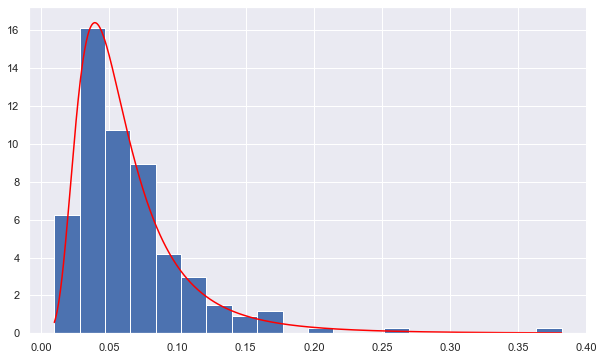

In [26]:
M_gaz = []
step = 10
i = step
while i < len(gaz_1800) + 1:
    M_gaz.append(max(gaz_1800[i-step:i]))
    i += step
print(len(M_gaz))

ksi_gaz, mu_gaz, sigma_gaz = sp.genextreme.fit(M_gaz)

plt.figure(figsize=(10, 6))
plt.hist(M_gaz, bins=20, density=True)
xs = np.linspace(min(M_gaz), max(M_gaz), 1000)
plt.plot(xs, sp.genextreme.pdf(xs, ksi_gaz, mu_gaz, sigma_gaz), c='red')
plt.show()

In [27]:
print("ksi: ", ksi_gaz, "\nmu: " ,mu_gaz, "\nsigma: ", sigma_gaz)

ksi:  -0.25558417212515766 
mu:  0.04451693907635269 
sigma:  0.023116117336861145


In [28]:
sp.kstest(M_gaz, 'genextreme', [ksi_gaz, mu_gaz, sigma_gaz])

KstestResult(statistic=0.038605429788992174, pvalue=0.9417280977118158, statistic_location=0.07108629106607045, statistic_sign=-1)

# Ropa

In [29]:
X_ropa = df['przyrosty_log_ropa'][df['przyrosty_log_ropa'] > 0]

In [30]:
# wybieram 1800 punktów (ostatnich, dodatnich logarytmicznych stóp zwrotu)
ropa_1800 = X_ropa[-n:]

In [31]:
ropa_1800 = ropa_1800.reset_index(drop=True)

180


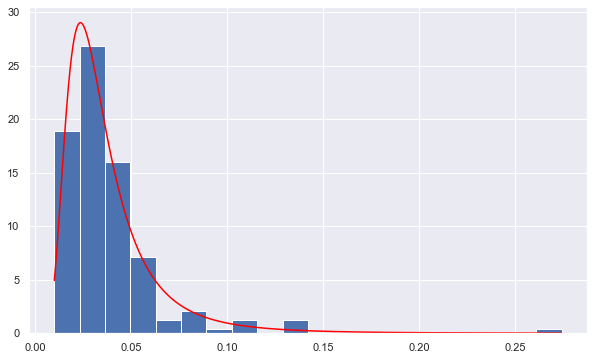

In [32]:
M_ropa = []
step = 10
i = step
while i < len(ropa_1800) + 1:
    M_ropa.append(max(ropa_1800[i-step:i]))
    i += step
print(len(M_ropa))

ksi_ropa, mu_ropa, sigma_ropa = sp.genextreme.fit(M_ropa)

plt.figure(figsize=(10, 6))
plt.hist(M_ropa, bins=20, density=True)
xs = np.linspace(min(M_ropa), max(M_ropa), 1000)
plt.plot(xs, sp.genextreme.pdf(xs, ksi_ropa, mu_ropa, sigma_ropa), c='red')
plt.show()

In [33]:
print("ksi: ", ksi_ropa, "\nmu: ", mu_ropa, "\nsigma: ", sigma_ropa)

ksi:  -0.26523583800893946 
mu:  0.026423851303666843 
sigma:  0.013085777649170904


# Inne podejście, liczymy oba surowce od tej samej daty, pewnie się na to zdecydujemy

W tym podejściu wybieramy dane z ostatnich 10 lat i dla nich dobiera się rozkład maksimum, czyli od kwietnia 2013 roku, z dodatnich zwrotów dla danego surowaca wybieram ten, który był największy w ciągu ostatnich 10 obserwacji

In [35]:
import scipy.stats as sp

In [36]:
df.loc[df["Data"] == '2013-04-17']

,Data,Cena gazu [USD/Million Btu],Cena ropy [USD/Barrel],przyrosty_log_gaz,przyrosty_log_ropa
1392,2013-04-17,4.2140,100.3600,0.0184,-0.0003


In [37]:
new_df = df[1392:].copy()

## Ropa

(nieintuicyjnie Z to ropa)

In [38]:
Z = new_df[:][new_df['przyrosty_log_ropa'] > 0]

In [39]:
#Z = Z[-n:]
Z = Z.reset_index(drop=True)
Z['index'] = Z.index
Z.head()

,Data,Cena gazu [USD/Million Btu],Cena ropy [USD/Barrel],przyrosty_log_gaz,przyrosty_log_ropa,index
0,2013-04-19,4.4080,99.6500,0.0016,0.0052,0
1,2013-04-22,4.2670,100.3900,-0.0325,0.0074,1
2,2013-04-24,4.1660,101.7300,-0.0171,0.0141,2
3,2013-04-25,4.1670,103.4100,0.0002,0.0164,3
4,2013-04-29,4.3920,103.8100,0.0562,0.0063,4


In [40]:
Z.shape

(1273, 6)

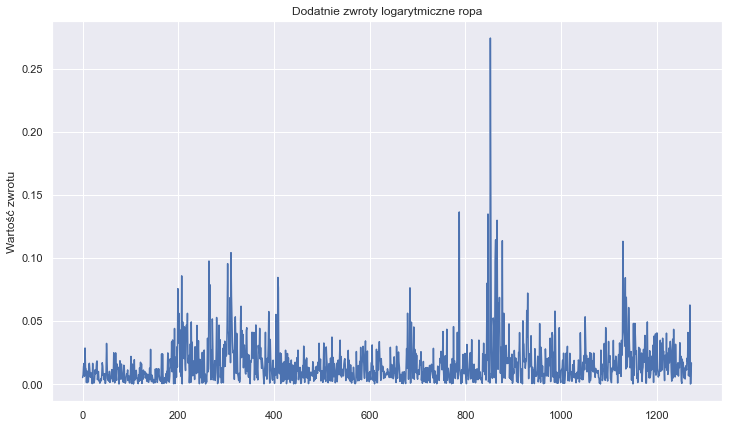

In [41]:
sns.lineplot(x=Z["index"], y=Z["przyrosty_log_ropa"])
plt.title('Dodatnie zwroty logarytmiczne ropa')
plt.xlabel('')
plt.ylabel('Wartość zwrotu')
# plt.savefig('log_przyrosty_dod_ropa.png')
plt.show()

In [42]:
max_ropa_10 = pd.DataFrame(columns = Z.columns)
m = 10
for i in range(Z.shape[0] + 1):
    row_ropa = Z[Z['przyrosty_log_ropa'] == Z['przyrosty_log_ropa'][m*i:m*(1+i)].max()]
    max_ropa_10 = pd.concat([max_ropa_10, row_ropa])

In [43]:
max_ropa_10.shape

(128, 6)

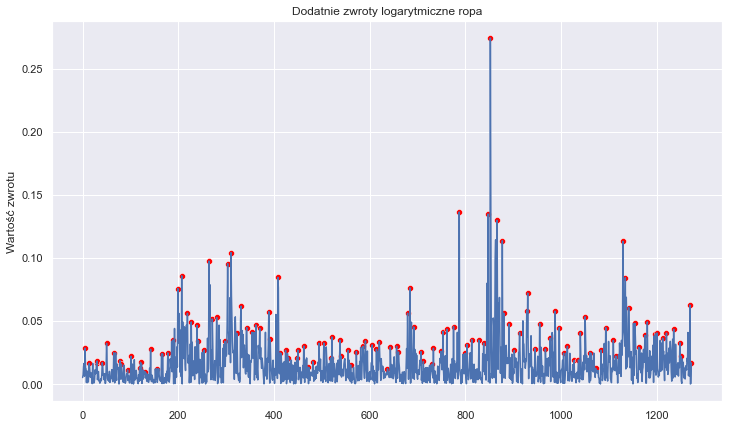

In [44]:
sns.scatterplot(x = max_ropa_10["index"], y = max_ropa_10["przyrosty_log_ropa"], color = "red")
sns.lineplot(x=Z["index"], y=Z["przyrosty_log_ropa"])
plt.title('Dodatnie zwroty logarytmiczne ropa')
plt.xlabel('')
plt.ylabel('Wartość zwrotu')
# plt.savefig('log_przyrosty_dod_ropa.png')
plt.show()

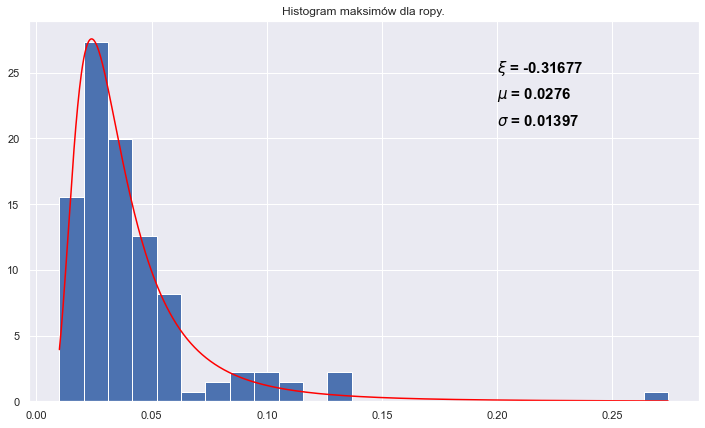

In [45]:
ksi_ropa, mu_ropa, sigma_ropa = sp.genextreme.fit(max_ropa_10['przyrosty_log_ropa'])
M_ropa = list(max_ropa_10['przyrosty_log_ropa'])

# plt.figure(figsize=(10, 6))
plt.title('Histogram maksimów dla ropy.')
plt.xlabel('')
plt.ylabel('')
plt.hist(M_ropa, bins=25, density=True)
xs = np.linspace(min(M_ropa), max(M_ropa), 1000)
plt.plot(xs, sp.genextreme.pdf(xs, ksi_ropa, mu_ropa, sigma_ropa), c='red')

plt.text(0.2, 25, (r"$\xi$ = " + str(np.round(ksi_ropa, 5))), horizontalalignment='left', size='15', color='black', weight='semibold')
plt.text(0.2, 23, (r"$\mu$ = " + str(np.round(mu_ropa, 5))), horizontalalignment='left', size='15', color='black', weight='semibold')
plt.text(0.2, 21, (r"$\sigma$ = " + str(np.round(sigma_ropa, 5))), horizontalalignment='left', size='15', color='black', weight='semibold')

plt.show()

In [46]:
print(ksi_ropa, mu_ropa, sigma_ropa)

-0.31677094210904894 0.027604921341161263 0.013969178353334156


In [47]:
np.round(ksi_ropa, 5)

-0.31677

## Gaz

In [48]:
G = new_df[:][new_df['przyrosty_log_gaz'] > 0]

In [49]:
G = G.reset_index(drop=True)
G['index'] = G.index
G.head()

,Data,Cena gazu [USD/Million Btu],Cena ropy [USD/Barrel],przyrosty_log_gaz,przyrosty_log_ropa,index
0,2013-04-17,4.2140,100.3600,0.0184,-0.0003,0
1,2013-04-18,4.4010,99.1300,0.0434,-0.0123,1
2,2013-04-19,4.4080,99.6500,0.0016,0.0052,2
3,2013-04-25,4.1670,103.4100,0.0002,0.0164,3
4,2013-04-29,4.3920,103.8100,0.0562,0.0063,4


In [50]:
G.shape

(1235, 6)

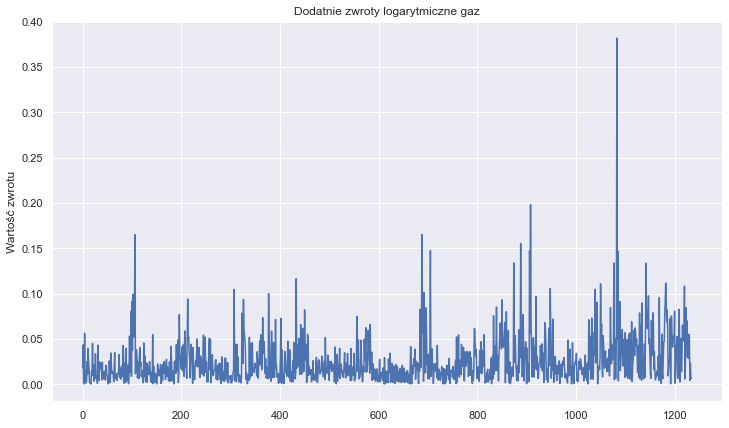

In [51]:
sns.lineplot(x=G["index"], y=G["przyrosty_log_gaz"])
plt.title('Dodatnie zwroty logarytmiczne gaz')
plt.xlabel('')
plt.ylabel('Wartość zwrotu')
# plt.savefig('log_przyrosty_dod_gaz.png')
plt.show()

In [52]:
max_gaz_10 = pd.DataFrame(columns = new_df.columns)
m = 10
for i in range(G.shape[0] + 1):
    row_gaz = G[G['przyrosty_log_gaz'] == G['przyrosty_log_gaz'][m*i:m*(1+i)].max()]
    max_gaz_10 = pd.concat([max_gaz_10, row_gaz])

In [53]:
max_gaz_10.shape

(124, 6)

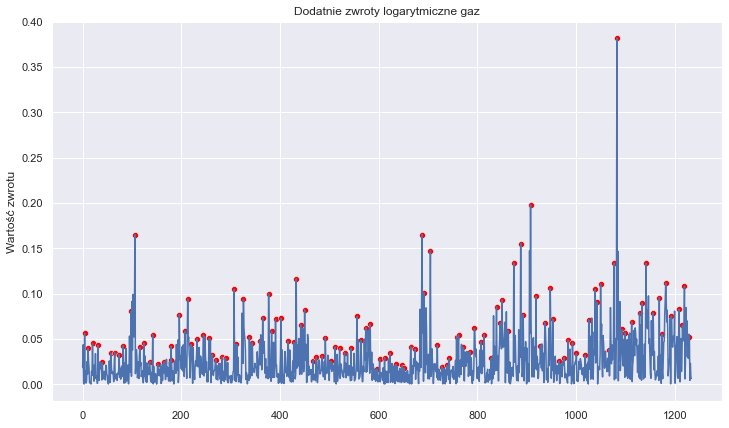

In [54]:
sns.scatterplot(x = max_gaz_10["index"], y = max_gaz_10["przyrosty_log_gaz"], color = "red")
sns.lineplot(x=G["index"], y=G["przyrosty_log_gaz"])
plt.title('Dodatnie zwroty logarytmiczne gaz')
plt.xlabel('')
plt.ylabel('Wartość zwrotu')
# plt.savefig('log_przyrosty_dod_gaz.png')
plt.show()

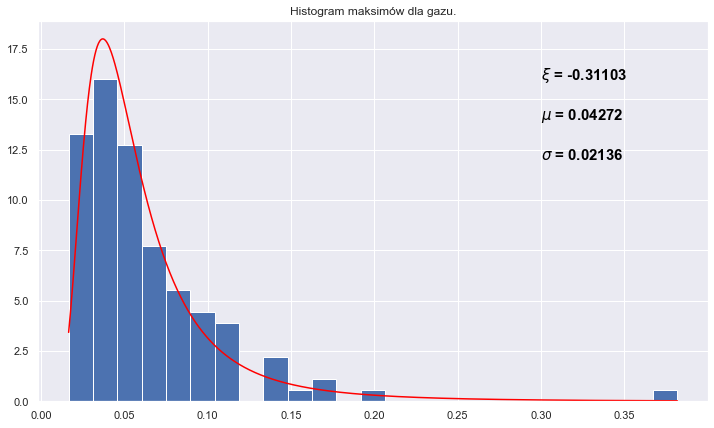

In [55]:
ksi_gaz, mu_gaz, sigma_gaz = sp.genextreme.fit(max_gaz_10['przyrosty_log_gaz'])
M_gaz = list(max_gaz_10['przyrosty_log_gaz'])

# plt.figure(figsize=(10, 6))
plt.title('Histogram maksimów dla gazu.')
plt.xlabel('')
plt.ylabel('')
plt.hist(M_gaz, bins=25, density=True)
xs = np.linspace(min(M_gaz), max(M_gaz), 1000)
plt.plot(xs, sp.genextreme.pdf(xs, ksi_gaz, mu_gaz, sigma_gaz), c='red')

plt.text(0.3, 16, (r"$\xi$ = " + str(np.round(ksi_gaz, 5))), horizontalalignment='left', size='15', color='black', weight='semibold')
plt.text(0.3, 14, (r"$\mu$ = " + str(np.round(mu_gaz, 5))), horizontalalignment='left', size='15', color='black', weight='semibold')
plt.text(0.3, 12, (r"$\sigma$ = " + str(np.round(sigma_gaz, 5))), horizontalalignment='left', size='15', color='black', weight='semibold')

plt.show()

In [56]:
print("ksi: ", ksi_gaz, "\nmu: " ,mu_gaz, "\nsigma: ", sigma_gaz)


ksi:  -0.3110254177560581 
mu:  0.04271648913562954 
sigma:  0.021361719573896883


# Koniec

# Testowanie wsteczne - nic niżej nie jest pewne

In [57]:
df.loc[df["Data"] == '2022-01-05'].index[0]

3556

In [58]:
test = df[df.loc[df["Data"] == '2020-04-14'].index[0]: ].copy()
train = df[ :df.loc[df["Data"] == '2020-04-14'].index[0]].copy()

# test = df[1936: ].copy()
# train = df[ :1936].copy()

test = test.reset_index(drop=True)
train = train.reset_index(drop=True)

In [59]:
test.shape

(747, 5)

In [60]:
train.shape

(3125, 5)

Testowanie kwantyla w przypadku jednowymiarowym oraz zmienności w przypadku dwuwymiarowym.

### Przypadek jednowymiarowy

In [61]:
def quantile_method(df, column_name, train, test, alpha):
    table = []

    for i in range(test.shape[0]):
        K_alpha = np.quantile(list(df[column_name][i:train.shape[0]+i]), alpha)
        if test[column_name][i] < K_alpha:
            table.append(1)
        else:
            table.append(0)
    return table

In [62]:
gaz_vec_05 = quantile_method(df, 'przyrosty_log_gaz', train, test, 0.05)
ropa_vec_05 = quantile_method(df, 'przyrosty_log_ropa', train, test, 0.05)
gaz_vec_01 = quantile_method(df, 'przyrosty_log_gaz', train, test, 0.01)
ropa_vec_01 = quantile_method(df, 'przyrosty_log_ropa', train, test, 0.01)

teoretyczna średnia to $\alpha$ 

---

teoretyczna wariancja to $\alpha(1 - \alpha)$

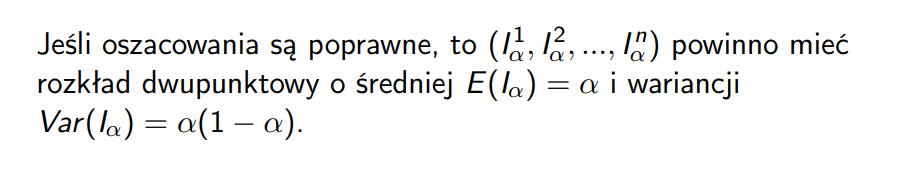

In [63]:
0.05*(1-0.05)

0.0475

In [64]:
np.mean(ropa_vec_05)

0.06559571619812583

In [65]:
np.var(ropa_vec_05)

0.06129291821458076

In [66]:
np.mean(ropa_vec_01)

0.013386880856760375

In [67]:
# brudnopis

In [68]:
przekroczenie_gaz_01 = []

for i in range(test.shape[0]):
    K_alpha = np.quantile(list(df['przyrosty_log_gaz'][i:train.shape[0]+i]), 0.05)
#     print(K_alpha)
    if test['przyrosty_log_gaz'][i] < K_alpha:
        przekroczenie_gaz_01.append(1)
    else:
        przekroczenie_gaz_01.append(0)        

In [69]:
np.mean(przekroczenie_gaz_01)

0.13386880856760375

In [70]:
np.var(przekroczenie_gaz_01)

0.11594795066029402

In [71]:
# teoretyczna wariancja 
0.05*(1-0.05)

0.0475

In [72]:
# koniec brudnopis

In [73]:
from scipy.stats import bartlett, f, levene

In [74]:
def find_p_value(var1, var2):
    bar_value, p_value_bar = bartlett(var1, var2)
    
    F_stat = var1.var()/var2.var()
    df1 = len(var1) - 1
    df2 = len(var2) - 1
    p_value_f = f.cdf(F_stat, df1, df2)
    
    levene_stat, p_value_lev = levene(var1, var2)
    
    return(p_value_f, p_value_bar, p_value_lev)

In [75]:
find_p_value(test['przyrosty_log_gaz'], train['przyrosty_log_gaz'])

(0.9999999999999999, 4.833606373029434e-78, 2.934999088965914e-42)

In [76]:
find_p_value(test['przyrosty_log_ropa'], train['przyrosty_log_ropa'])

(0.9999999999972564, 5.981232075002542e-12, 3.2416616101520404e-06)

test F często kłamie gdy dane nie sa normalne, a Gosia pokazała że nie są normalne, w takim przypadku lepiej używać testu Bartletta lub Levene'a